In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import lmfit
from tqdm.auto import tqdm
import pickle
import joblib

### Load spb covid-19 dataset

In [2]:
data = pd.read_csv('spb.combined.daily.txt', '\t', parse_dates=['TIME'], encoding='cp1251')

In [3]:
data.head()

,TIME,CONFIRMED,RECOVERED,DEATHS,ACTIVE,CONFIRMED.spb,HOSPITALIZED.today,PCR.tested,v1.CS,v2.CS,Yandex.ACTIVITY.points
0,2020-03-02,0,0,0,0,NaN,NaN,NaN,NaN,NaN,97.0
1,2020-03-03,0,0,0,0,NaN,NaN,NaN,NaN,NaN,100.0
2,2020-03-04,1,0,0,1,NaN,NaN,NaN,NaN,NaN,99.0
3,2020-03-05,0,0,0,1,NaN,NaN,NaN,NaN,NaN,99.0
4,2020-03-06,1,0,0,2,NaN,NaN,NaN,NaN,NaN,100.0


### Considering the first phase

In [4]:
data1 = data[data.TIME <= '2020-06-30']

In [5]:
data1.drop(['Yandex.ACTIVITY.points', 'v1.CS', 'v2.CS', 'CONFIRMED.spb', 'PCR.tested'], axis =1 , inplace = True)

/home/pk/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [6]:
data1.fillna(0, inplace = True )

/home/pk/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [7]:
data1

,TIME,CONFIRMED,RECOVERED,DEATHS,ACTIVE,HOSPITALIZED.today
0,2020-03-02,0,0,0,0,0.0
1,2020-03-03,0,0,0,0,0.0
2,2020-03-04,1,0,0,1,0.0
3,2020-03-05,0,0,0,1,0.0
4,2020-03-06,1,0,0,2,0.0
...,...,...,...,...,...,...
116,2020-06-26,224,716,57,6242,525.0
117,2020-06-27,217,598,21,5840,358.0
118,2020-06-28,219,247,19,5793,216.0
119,2020-06-29,253,254,31,5761,375.0


### Plot of active cases dring first wave

<AxesSubplot:>

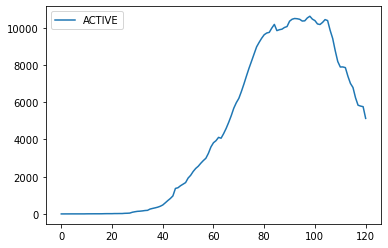

In [8]:
data1.ACTIVE.plot(legend = True)

<AxesSubplot:>

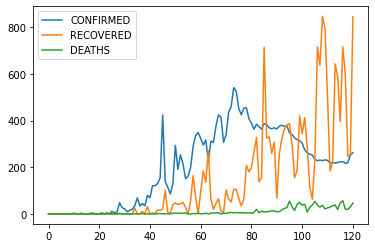

In [9]:
data1.CONFIRMED.plot(legend = True)
data1.RECOVERED.plot(legend = True)
data1.DEATHS.plot(legend = True)

### Building SIER model. 


In [10]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# parameter values
R0 = 1.0889
t_incubation = 0.106
t_infective = 0.649

# initial number of infected and recovered individuals
e_initial = 1/4000000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -beta * s * i
    dedt =  beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]


t = np.linspace(0, 121, 121)
x_initial = s_initial, e_initial, i_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
s, e, i, r = soln.T


#### Find the best parameters to fit the model

In [11]:
R0 = np.arange(1.088, 1.089, 0.0001)
t_incubation = np.arange(0.1, 0.2, 0.001)
t_infective = np.arange(0.45, 0.65, 0.001)

In [12]:
# r2_scores = {}
# for x in R0:
#     for y in t_incubation:
#         for z in t_infective:
#             alpha = 1/y
#             gamma = 1/z
#             beta = x*gamma
#             soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
#             s, e, i, r = soln.T
#             R2 = r2_score(data1['ACTIVE'][:], i*4000000 )
#             r2_scores[f'R0:{x}, t_incubation:{y}, t_infective:{z}'] = R2


In [13]:
# sorted(r2_scores.items(), key=lambda x: x[1], reverse=True)

#### Best parameters obtained are 
R0 = 1.0889
t_incubation = 0.106
t_infective = 0.649

#### Plot of actual and predicted active cases

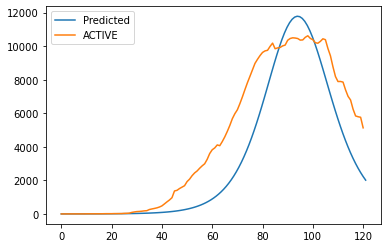

In [14]:
plt.plot(t, i*4000000, label='Predicted')
((data1.ACTIVE)).plot(legend = True)
plt.legend()

In [15]:
R2 = r2_score(data1['ACTIVE'][:], i*4000000 )
R2

0.7737791695895329

### R2 score for the model is 0.7737791695895329

## MCMC for finding best parameters for SEIR model

## Metropolis hasting calibrated with SEIR

In [16]:
# import required packages
import numpy as np
import os
import scipy.io as sio
from scipy.integrate import odeint
from pymcmcstat.MCMC import MCMC
from pymcmcstat.plotting import MCMCPlotting
import matplotlib.pyplot as plt
import pymcmcstat
import pandas as pd
print(pymcmcstat.__version__)
np.seterr(over='ignore');

1.9.1


In [17]:
# tx corresponds to the days, and ty to the active cases
tx = np.arange(len(data1))
ty = data1[['CONFIRMED', 'ACTIVE', 'RECOVERED' ]].values

In [18]:
# Build a loss function (sum of squares)
def covid_ss(theta, data):
    # sum-of-squares function for covid example
    ndp, nbatch = data.shape[0]
    time = tx
    ydata = ty
    xdata = data.user_defined_object[0]
    # last 3 parameters are the initial states
    y0 = x_initial
    # evaluate model
    tmodel, ymodel = covid_fun(time, theta, y0, xdata)
#     a_model = np.cumsum(ymodel[:,2]-(ymodel[:,3]+ymodel[:,4]))
    res = ymodel[:,2] - ty[:,1]/4000000
    ss = (res**2).sum(axis=0)
    return ss  

# Building SIERD model
def covid_fun(time, theta, y0, xdata  = None):
    soln = odeint(covid_sys, y0, time, args=(theta, xdata))
#     s, e, i, r = soln.T   
    return time, soln


e_initial = 1/4000000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial
x_initial = s_initial, e_initial, i_initial, r_initial

def covid_sys(y, t ,theta, xdata = None):
    s, e, i, r = y
    
    R0 = theta[0]
    t_incubation = theta[1]
    t_infective = theta[2]
    alpha = 1/t_incubation
    gamma = 1/t_infective
    beta = R0*gamma
    
#     s, e, i, r = x
    dsdt = -beta * s * i
    dedt =  beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    ydot = np.array([dsdt, dedt, didt, drdt])
    return ydot


In [19]:
# initialize MCMC object
mcstat = MCMC()
# initialize data structure 
mcstat.data.add_data_set(x=tx,
                         y=ty[:,:],
                         user_defined_object=tx)
# initialize parameter array
# add model parameters
# Intially population o SPB is considered as 10000000 and all the intial parameters for SIERD model are defined
mcstat.parameters.add_model_parameter(name='R0', theta0=1.0889, minimum=0, maximum = 2)
mcstat.parameters.add_model_parameter(name='t_incubation', theta0=0.106, minimum=0, maximum=2)
mcstat.parameters.add_model_parameter(name='t_infective', theta0=0.649, minimum=0, maximum=2)
                                  


# Generate options
mcstat.simulation_options.define_simulation_options(nsimu=1.0e3, updatesigma=True)


In [20]:
# Define model object:

mcstat.model_settings.define_model_settings(
    sos_function=covid_ss)

In [21]:
# # check model evaluation
# theta = [1.0889, 0.106, 0.649]
# ss = covid_ss(theta, mcstat.data)
# print('ss = {}'.format(ss))

In [22]:
# Run simulation
mcstat.run_simulation()
# Rerun starting from results of previous run
mcstat.simulation_options.nsimu = int(5.0e3)
mcstat.run_simulation(use_previous_results=True)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        R0:      1.09 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
t_incubation:      0.11 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
t_infective:      0.65 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 1000 of 1000 complete in 2.5 sec
Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        R0:      1.09 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
t_incubation:      0.01 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
t_infective:      0.75 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 10.8 sec



------------------------------
      name:      mean       std    MC_err       tau    geweke
        R0:      1.09  3.13e-03  3.35e-04     47.98      1.00
t_incubation:      0.03      0.04  3.88e-03     46.83      0.95
t_infective:      0.72      0.02  1.86e-03     25.49      1.00
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 14.26%
Stage 2: 50.52%
Net    : 64.78% -> 3239/5000
---------------
Chain provided:
Net    : 67.88% -> 2375/3499
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


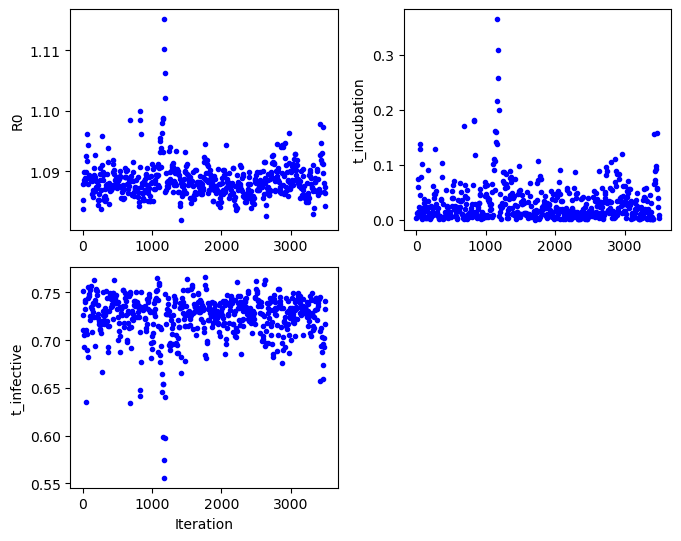

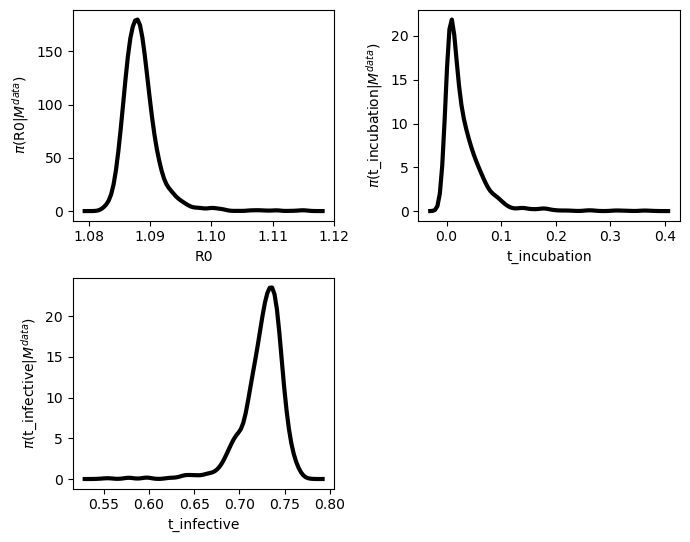

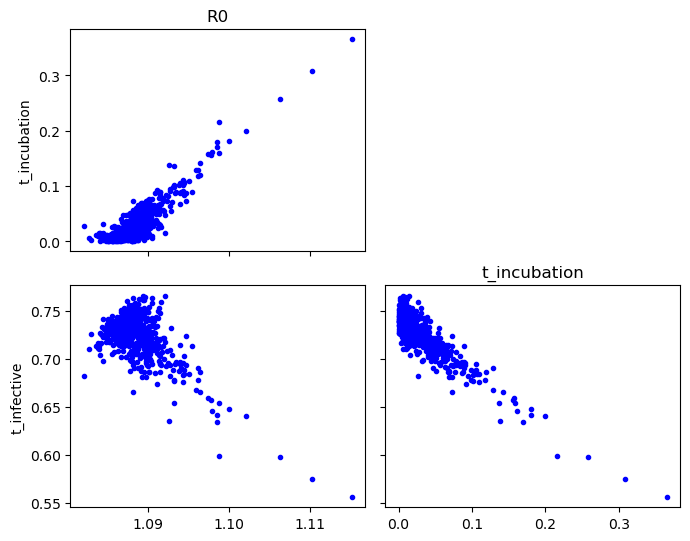

In [23]:
# extract info from results
results = mcstat.simulation_results.results
burnin = int(results['nsimu']/2)
chain = results['chain'][burnin:, :]
s2chain = results['s2chain'][burnin:, :]
names = results['names'] # parameter names

# display chain stats
mcstat.chainstats(chain, results)

from pymcmcstat import mcmcplot as mcp
settings = dict(
    fig=dict(figsize=(7, 6))
)
# plot chain panel
mcp.plot_chain_panel(chain, names, settings)
# plot density panel
mcp.plot_density_panel(chain, names, settings)
# pairwise correlation
f = mcp.plot_pairwise_correlation_panel(chain, names, settings)

### Optimal Parameters predicted using MCMC.
R0 = 1.09
t_incubation = 0.11
t_infective = 0.67

In [24]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# parameter values
R0 = 1.09
t_incubation = 0.02
t_infective = 0.73

# initial number of infected and recovered individuals
e_initial = 1/4000000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma
# delta = 
# rho = 

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -beta * s * i
    dedt =  beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]


t = np.linspace(0, 121, 121)
x_initial = s_initial, e_initial, i_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
s, e, i, r = soln.T


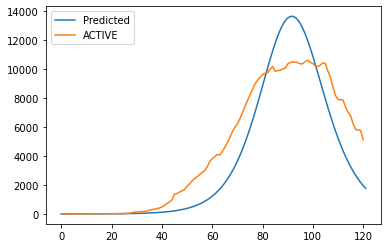

In [25]:
plt.plot(t, i*4000000, label='Predicted')
((data1.ACTIVE)).plot(legend = True)
plt.legend()

In [26]:
R2 = r2_score(data1['ACTIVE'][:], i*4000000 )
R2

0.7823574162110154

### R2 score for the model calibrated with MCMC to find the best parameters is 0.7775169378287957


In [27]:
from pymcmcstat import propagation as up

def predmodel(q, data):
    obj = data.user_defined_object[0]
    time = obj[:]
    xdata = obj
    # last 3 parameters are the initial states
    y0 = x_initial
    # evaluate model
    ymodel = np.zeros([time.size])
    tmodel, ymodel = covid_fun(time, q, y0, xdata)
    return ymodel

pdata = mcstat.data
intervals = up.calculate_intervals(chain, results, pdata, predmodel,
                                  waitbar=True, s2chain=s2chain)

 [-----------------100%-----------------] 500 of 500 complete in 0.6 sec

#### Get the predictions from the distribution of data

In [28]:
# getting the predictions from the generated 500 samples for each day.
pred = []
for i in range(len(data1)):
    pred.append(intervals[2]['prediction'][:,i].mean())

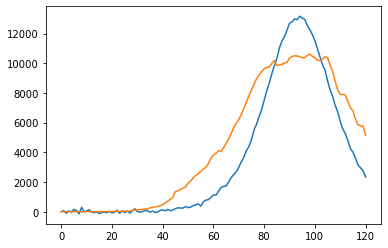

In [29]:
plt.plot(np.arange(121), np.array(pred)*4000000)
plt.plot(mcstat.data.xdata[0][:,0],mcstat.data.ydata[0][:,1])


In [30]:
R2 = r2_score(mcstat.data.ydata[0][:,1], np.array(pred)*4000000)
R2

0.805506415519301

### R2 score for the model calibrated with MCMC to find the best parameters is 0.7940174702659524

In [31]:
# Build a loss function (sum of squares)
def covid_ss(theta, data):
    # sum-of-squares function for covid example
    ndp, nbatch = data.shape[0]
    time = tx
    ydata = ty
    xdata = data.user_defined_object[0]
    # last 3 parameters are the initial states
    y0 = x_initial
    # evaluate model
    tmodel, ymodel = covid_fun(time, theta, y0, xdata)
#     a_model = np.cumsum(ymodel[:,2]-(ymodel[:,3]+ymodel[:,4]))
    res = (ymodel[:,2] - ty[:,1]/4000000)**2
    ss = np.mean(res)
    return ss  

# Building SIERD model
def covid_fun(time, theta, y0, xdata  = None):
    soln = odeint(covid_sys, y0, time, args=(theta, xdata))
#     s, e, i, r = soln.T   
    return time, soln


# e_initial = 1/4000000
# i_initial = 0.00
# r_initial = 0.00
# s_initial = 1 - e_initial - i_initial - r_initial
# x_initial = s_initial, e_initial, i_initial, r_initial

def covid_sys(y, t ,theta, xdata = None):
    s, e, i, r = y
    
    beta = theta[0]
    gamma = theta[1]
    sigma = theta[2]    
    mu = theta[3]
    
#     s, e, i, r = x
    dsdt = -beta * s * (i+e)
    dedt =  beta * s * (i+e) - sigma * e
    didt = mu * sigma * e - gamma * i
    drdt =  gamma * i
    ydot = np.array([dsdt, dedt, didt, drdt])
    return ydot


In [32]:
# initialize MCMC object
mcstat = MCMC()
# initialize data structure 
mcstat.data.add_data_set(x=tx,
                         y=ty[:,:],
                         user_defined_object=tx)
# initialize parameter array
# add model parameters
# Intially population o SPB is considered as 10000000 and all the intial parameters for SIERD model are defined
mcstat.parameters.add_model_parameter(name='beta', theta0=1, minimum=0, maximum = 2)
mcstat.parameters.add_model_parameter(name='gamma', theta0=1, minimum=0, maximum=2)
mcstat.parameters.add_model_parameter(name='sigma', theta0=1, minimum=0, maximum=2)
mcstat.parameters.add_model_parameter(name='mu', theta0=1, minimum=0.8, maximum=1)
                                  


# Generate options
mcstat.simulation_options.define_simulation_options(nsimu=1.0e3, updatesigma=True)


In [33]:
# Define model object:

mcstat.model_settings.define_model_settings(
    sos_function=covid_ss)

In [34]:
# Run simulation
mcstat.run_simulation()
# Rerun starting from results of previous run
mcstat.simulation_options.nsimu = int(5.0e3)
mcstat.run_simulation(use_previous_results=True)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
      beta:      1.00 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
     gamma:      1.00 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
     sigma:      1.00 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
        mu:      1.00 [     0.80,      1.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 1000 of 1000 complete in 2.6 sec
Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
      beta:      0.94 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
     gamma:      1.56 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
     sigma:      1.48 [ 0.00e+00,      2.00] N( 0.00e+00,      inf)
        mu:      0.81 [     0.80,      1.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 13.7 sec



------------------------------
      name:      mean       std    MC_err       tau    geweke
      beta:      0.93      0.04  7.38e-03    293.49      0.87
     gamma:      1.64      0.11      0.02    199.81      0.83
     sigma:      1.57      0.20      0.04    365.24      0.61
        mu:      0.91      0.06  7.24e-03    108.63      0.99
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 3.78%
Stage 2: 25.66%
Net    : 29.44% -> 1472/5000
---------------
Chain provided:
Net    : 32.18% -> 1126/3499
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


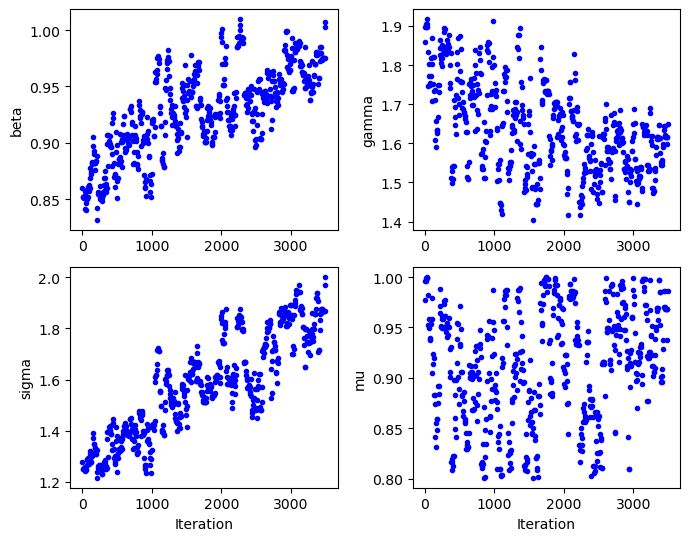

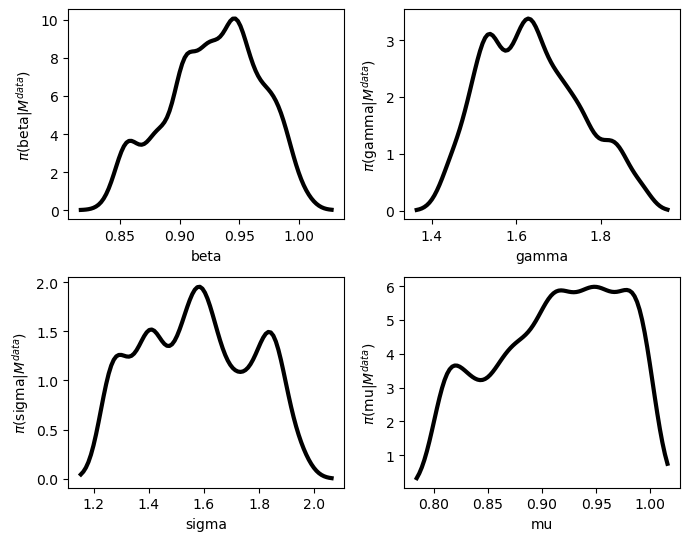

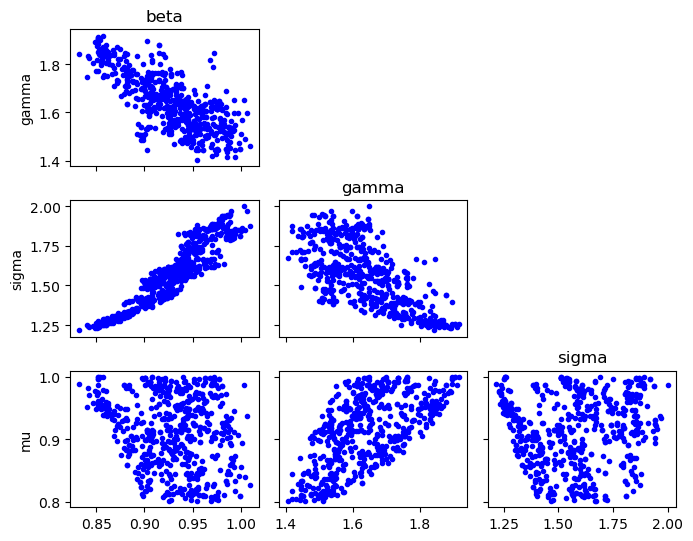

In [35]:
# extract info from results
results = mcstat.simulation_results.results
burnin = int(results['nsimu']/2)
chain = results['chain'][burnin:, :]
s2chain = results['s2chain'][burnin:, :]
names = results['names'] # parameter names

# display chain stats
mcstat.chainstats(chain, results)

from pymcmcstat import mcmcplot as mcp
settings = dict(
    fig=dict(figsize=(7, 6))
)
# plot chain panel
mcp.plot_chain_panel(chain, names, settings)
# plot density panel
mcp.plot_density_panel(chain, names, settings)
# pairwise correlation
f = mcp.plot_pairwise_correlation_panel(chain, names, settings)

In [36]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# parameter values


# initial number of infected and recovered individuals
e_initial = 1/4000000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial
mu = 0.93

beta = 0.91
gamma = 1.73
sigma = 1.51
mu = 0.97
# delta = 
# rho = 
# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -beta * s * (i+e)
    dedt =  beta * s * (i+e) - sigma * e
    didt = mu * sigma * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]


t = np.linspace(0, 121, 121)
x_initial = s_initial, e_initial, i_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
s, e, i, r = soln.T


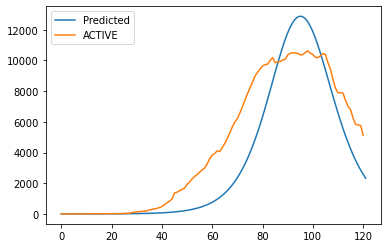

In [37]:
plt.plot(t, i*4000000, label='Predicted')
((data1.ACTIVE)).plot(legend = True)
plt.legend()

In [38]:
R2 = r2_score(data1['ACTIVE'][:], i*4000000 )
R2

0.7684249238450018

In [59]:
from scipy.optimize import minimize
# Build a loss function (sum of squares)
def covid_ss(theta):
    # sum-of-squares function for covid example
    time = np.arange(121)
    ydata = ty
    # last 3 parameters are the initial states
    y0 = x_initial
    # evaluate model
    ymodel = covid_fun(time, theta, y0)
    res = (ymodel[:,2] - ty[:,1]/4000000)
    ss = (res**2).sum(axis=0)
    return ss  

# Building SIERD model
def covid_fun(time, theta, y0):
    soln = odeint(covid_sys, y0, time, args=(theta,))
#     s, e, i, r = soln.T   
    return soln


e_initial = 1/4000000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial
x_initial = s_initial, e_initial, i_initial, r_initial

def covid_sys(y, t ,theta):
    s, e, i, r = y
    
    beta = theta[0]
    gamma = theta[1]
    sigma = theta[2]    
    mu = theta[3]
    
    dsdt = -beta * s * (i+e)
    dedt =  beta * s * (i+e) - sigma * e
    didt = mu * sigma * e - gamma * i
    drdt =  gamma * i
    ydot = np.array([dsdt, dedt, didt, drdt])
    return ydot


In [60]:
optimal = minimize(
    covid_ss,
    [0.2, .5e-2, 2.5e-1, 0.01],
    method='L-BFGS-B'
)


In [64]:
covid_ss([0.29  , 9.005, 0.25 , 1 ])

0.0002812140330996065

In [61]:
optimal

      fun: 0.0002812110268772799
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.01443376e-07,  2.55676556e-07,  6.96708316e-08, -5.67628626e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 5
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.2  , 0.005, 0.25 , 0.01 ])

In [48]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# parameter values


# initial number of infected and recovered individuals
e_initial = 1/4000000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial
mu = 0.93

beta = 0.2
gamma = 0.005
sigma = 0.25
mu = 0.01
# delta = 
# rho = 
# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -beta * s * (i+e)
    dedt =  beta * s * (i+e) - sigma * e
    didt = mu * sigma * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]


t = np.linspace(0, 121, 121)
x_initial = s_initial, e_initial, i_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
s, e, i, r = soln.T


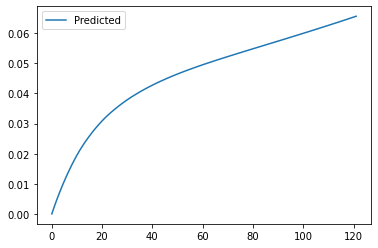

In [50]:
plt.plot(t, i*4000000, label='Predicted')
# ((data1.ACTIVE)).plot(legend = True)
plt.legend()

In [131]:
model = Learner_SuEIR(N=4000000, E_0=1, I_0=0, R_0=0)
prev_params = [50, 1.5, 3e-1, 0.001]
train_data = data1
data_confirm, data_fatality = data1.CONFIRMED, data1.RECOVERED

init = [4000000,1,0,0]
# params, train_loss = train(model, init, prev_params, train_data)

In [ ]:
model(121, prev_params, init)

In [120]:
params

array([0.3       , 0.03207513, 0.64454416, 0.001     ])

In [117]:
params, train_loss = train(model, init, prev_params, train_data)

KeyboardInterrupt: 

In [ ]:
pred = model(len(data_confirm), params, init)

In [141]:
class Learner_SuEIR():
    def __init__(self, N, E_0, I_0, R_0, a, decay, bias=0.005):
        self.N = N
        self.E_0 = E_0
        self.I_0 = I_0
        self.R_0 = R_0
        self.a = a
        self.decay = decay
        self.FRratio = a * \
            np.minimum(np.exp(-decay * (np.arange(1000) + 0)), 1)+bias
        self.pop_in = 0
        self.pop = N*5
        self.bias=1000000

        self.initial_N = N
        self.initial_pop_in = self.pop_in
        self.initial_bias=1000000

    def __call__(self, size, params, init, lag=0):

        beta, gamma, sigma, mu = params

        def calc_grad(t, y):
            S, E, I, _ = y

            # new population joining the suspecitible population
            new_pop_in = self.pop_in*(self.pop-self.N)*(np.exp(-0.03*np.maximum(0, t-self.bias))+0.05) 
            return [new_pop_in-beta*S*(E+I)/self.N, beta*S*(E+I)/self.N-sigma*E, mu*E-gamma*I, gamma*I]

        solution = solve_ivp(
            calc_grad, [0, size], init, t_eval=np.arange(0, size, 1))

        # returned solution is [S, E, I, R]
        # Removed perday
        temp_r_perday = np.diff(solution.y[3])
        # Since SuEIR does not provide death dynamic, estimate death
        # grab FR_ratio per day * r perday
        temp_F_perday = temp_r_perday * \
            self.FRratio[lag:len(temp_r_perday)+lag]
        # Since the -1 day info is not accessable, we treat the ddeath of 0 day is exactly the R_0
        # which means no recover before 0-day. Then calculated cumulative death.
        temp_F = np.empty(len(temp_F_perday) + 1)
        np.cumsum(temp_F_perday, out=temp_F[1:])
        temp_F[0] = 0
        temp_F += solution.y[3][0]

        # Note that I is the active cases instead of the cumulative confirmed
        # Confirm = I + R, death is prior estimated
        # return pred_S, pred_E, pred_I, pred_R, pred_confirm, pred_fatality
        return solution.y[0], solution.y[1], solution.y[2], solution.y[3], solution.y[2] + solution.y[3], temp_F

    def reset(self):
        self.N = self.initial_N
        self.pop_in = self.initial_pop_in
        self.bias = self.initial_bias





In [151]:
def train(model, init, prev_params, train_data, reg=0, lag=0):

    data_confirm, data_fatality = train_data.CONFIRMED, train_data.RECOVERED
    size = len(data_confirm)
    fatality_perday = np.diff(data_fatality)
    target_ave_fatality_perday = np.median(
        fatality_perday[np.maximum(0, len(fatality_perday)-7):])
    confirm_perday = np.diff(data_confirm)
    target_ave_confirm_perday = np.median(
        confirm_perday[np.maximum(0, len(confirm_perday)-7):])

    def loss_train(params):

        _, _, _, pred_remove, pred_confirm, pred_fatality = model(size, params, init, lag)

        pred_fatality = pred_fatality + data_fatality[0] - pred_fatality[0]
        reg = 0.5

        pred_ave_confirm_perday = np.mean(np.maximum(0, np.diff(pred_confirm)[-7:]))
        pred_ave_fatality_perday = np.mean(np.maximum(0, np.diff(pred_fatality)[-7:]))

        # pick_inds = np.arange(0, len(data_fatality), 7)
        # pick_inds = pick_inds + len(data_fatality)-1 - pick_inds[-1]

        # pred_confirm_wk, pred_fatality_wk, data_confirm_wk, data_fatality_wk  \
        # = pred_confirm[pick_inds], pred_fatality[pick_inds], data_confirm[pick_inds], data_fatality[pick_inds]

        reg_loss = loss(np.array(params[2]), np.array(prev_params[2]), smoothing=0)
        # print(np.diff(data_confirm_wk),np.diff(pred_confirm_wk))
        # return loss((pred_confirm_wk), (data_confirm_wk)) \
        #  + loss((pred_fatality_wk), (data_fatality_wk)) \
        #  + 0.1*loss(np.diff(pred_confirm_wk), np.diff(data_confirm_wk)) \
        #   + 0.1*loss(np.diff(pred_fatality_wk), np.diff(data_fatality_wk)) 
            # + 0.5*loss(pred_ave_confirm_perday, target_ave_confirm_perday) + 0.5 * \
            # loss(pred_ave_fatality_perday, target_ave_fatality_perday) + reg * reg_loss

        return loss(pred_confirm, data_confirm) + 1*loss(pred_fatality, data_fatality) 
        + 1*loss(pred_ave_confirm_perday, target_ave_confirm_perday) + 3 * \
            loss(pred_ave_fatality_perday, target_ave_fatality_perday) 

    optimal = minimize(
        loss_train,
        [0.2, .5e-2, 2.5e-1, 0.01],
        method='L-BFGS-B',
        bounds=[(0.0001, 2), (0.001, 2), (0.01, 1), (0.001, 1.)]
    )

    return optimal.x, optimal.fun




In [152]:
N = 60000000
E = N/50


# data = NYTimes(level='states')
a, decay = 0.75, 0.033
# state = "California"

train_data = data1
data_confirm, data_fatality = train_data.CONFIRMED, train_data.RECOVERED

init = [N-E-data_confirm[0]-data_fatality[0],
        E, data_confirm[0], data_fatality[0]]
model = Learner_SuEIR(N=N, E_0=E, I_0=data_confirm[0], R_0=data_fatality[0], a=a, decay=decay)

In [153]:
train(model, init, params, train_data)

(array([1.00000000e-04, 2.86123964e-03, 1.00000000e+00, 1.00000000e-03]),
 9.091982004373683)

In [149]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


# initial number of infected and recovered individuals
e_initial = 1/4000000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

beta, gamma, sigma, mu = [1.00000000e-04, 2.86123964e-03, 1.00000000e+00, 1.00000000e-03]



# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -beta * s * (i+e)
    dedt =  beta * s * (i+e) - sigma * e
    didt = mu * sigma * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]


t = np.linspace(0, 121, 121)
x_initial = s_initial, e_initial, i_initial, r_initial
soln = odeint(deriv, init, t, args=(alpha, beta, gamma))
s, e, i, r = soln.T


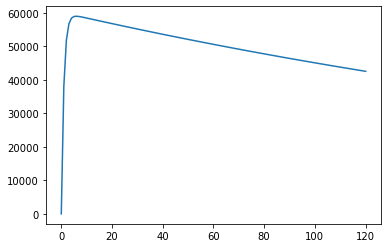

In [150]:
plt.plot(np.arange(121), i)

In [ ]:
def loss_train(params):

    pred_suspected, pred_remove, pred_confirm, pred_fatality = model(121, params, init)
    data_confirm, data_fatality = train_data.CONFIRMED, train_data.RECOVERED
    return loss(pred_confirm, data_confirm) + loss(pred_fatality, data_fatality) 

R0 = 1.0889
t_incubation = 0.106
t_infective = 0.649


alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma
mu = 0.9
params = [alpha, beta, gamma, mu]
optimal = minimize(
        loss_train,
        params,
        method='L-BFGS-B'
    )


In [113]:
class Learner_SuEIR():
    def __init__(self, N, E_0, I_0, R_0):
        self.N = N
        self.E_0 = E_0
        self.I_0 = I_0
        self.R_0 = R_0


    def __call__(self, size, params, init):

        beta, gamma, sigma, mu = params

        def calc_grad(t, y):
            s,e,i,r = y
            dsdt = -beta * s * (i+e)
            dedt =  beta * s * (i+e) - sigma * e
            didt = mu * sigma * e - gamma * i
            drdt =  gamma * i
            ydot = np.array([dsdt, dedt, didt, drdt])
            return ydot

        solution = solve_ivp(
            calc_grad, [0, size], init, t_eval=np.arange(0, size, 1))


        return solution.y[0], solution.y[1], solution.y[2], solution.y[3]




In [128]:
import numpy as np
from scipy.optimize import minimize


def loss(pred, target, smoothing=10):
    # print (pred)
    return np.mean((np.log(pred+smoothing) - np.log(target+smoothing))**2)

def train(model, init, prev_params, train_data):

    data_confirm, data_fatality = train_data.CONFIRMED, train_data.RECOVERED

    size = len(data_confirm)
    
    def loss_train(params):

        pred_suspected, pred_remove, pred_confirm, pred_fatality = model(size, params, init)
       
        return loss(pred_confirm, data_confirm) + loss(pred_fatality, data_fatality) 


    optimal = minimize(
        loss_train,
        [50, 1.5, 2.5e-1, 0.001],
        method='L-BFGS-B'
    )

    return optimal.x, optimal.fun


def rolling_train(model, init, train_data, new_sus):

    params_all = []
    loss_all = []
    prev_params = [0.2, .5e-2, 3e-1, 0.01]
    N = model.N

    # print (mean_increase, pop_in)
    data_confirm, data_fatality = data1.CONFIRMED, data1.RECOVERED
    params, train_loss = train(model, init, prev_params, data1)
    pred_sus, pred_exp, pred_act, pred_remove = model(len(data_confirm), params, init)
    # print(params)


    true_remove = np.minimum(data_confirm[-1], pred_remove[-1])

    init = [pred_sus[-1], pred_exp[-1], data_confirm[-1]-true_remove, true_remove]
    init[0] = init[0] + new_sus
    model.N += new_sus
    # print (params, train_loss)
    prev_params = params
    params_all += [params]
    loss_all += [train_loss]
    
    
    init[0] = init[0] - new_sus
    model.reset()
    pred_sus, pred_exp, pred_act, pred_remove, pred_confirm, pred_fatality = model(7, params, init)
        
    return params_all, loss_all 



# if __name__ == '__main__':


#     N = 6000000
#     E = N/70

#     # N = 6585370
#     # E = N/70



#     train_data = data1
#     data_confirm, data_fatality = train_data['CONFIRMED'], train_data['RECOVERED']

#     init = [N-E-data_confirm[0]-data_fatality[0],
#             E, data_confirm[0], data_fatality[0]]


#     model = Learner_SuEIR(N=N, E_0=E, I_0=data_confirm[0], R_0=data_fatality[0])

#     params_all, loss_all = rolling_train(model, init, train_data, new_sus=N/2)
    
#     pred_confirm, pred_fatality, _ = rolling_prediction(model, init, params_all, train_data, new_sus=N/2, pred_range=7)
#     print(np.diff(pred_confirm))
#     print (pred_confirm)

#     confirm = train_data[0][0][0:-1].tolist() + train_data[1][0][0:-1].tolist() + pred_confirm.tolist()
#     plt.figure()
#     plt.plot(np.diff(np.array(confirm)))
#     plt.savefig("figure/daily_increase.pdf")
#     # print(np.diff(np.array(confirm)))
#     plt.close()
#     print(pred_fatality + train_data[-1][1][-1] - pred_fatality[0])

In [113]:
class Learner_SuEIR():
    def __init__(self, N, E_0, I_0, R_0):
        self.N = N
        self.E_0 = E_0
        self.I_0 = I_0
        self.R_0 = R_0


    def __call__(self, size, params, init):

        beta, gamma, sigma, mu = params

        def calc_grad(t, y):
            s,e,i,r = y
            dsdt = -beta * s * (i+e)
            dedt =  beta * s * (i+e) - sigma * e
            didt = mu * sigma * e - gamma * i
            drdt =  gamma * i
            ydot = np.array([dsdt, dedt, didt, drdt])
            return ydot

        solution = solve_ivp(
            calc_grad, [0, size], init, t_eval=np.arange(0, size, 1))



        # Note that I is the active cases instead of the cumulative confirmed
        # Confirm = I + R, death is prior estimated
        # return pred_S, pred_E, pred_I, pred_R, pred_confirm, pred_fatality
        return solution.y[0], solution.y[1], solution.y[2], solution.y[3]




In [ ]:
model = Learner_SuEIR(1, 1/4000000, 0, 0)
pred = model(121, [1.0889/0.649, 1/0.649, 1/0.106, 0.001],[1, 1/4000000, 0,0] )

In [ ]:
plt.plot(np.arange(121),pred[2])

In [ ]:
plt.plot(np.arange(121), pred[4])
